In [72]:
# install kaggle
!pip install kaggle

# upload kaggle
from google.colab import files
files.upload()  # select kaggle.json

# configure credentials
!mkdir -p ~/.kaggle
!mkdir -p ~/.config/kaggle
!cp kaggle.json ~/.kaggle/kaggle.json
!cp kaggle.json ~/.config/kaggle/kaggle.json
!chmod 600 ~/.kaggle/kaggle.json
!chmod 600 ~/.config/kaggle/kaggle.json

# authenticate
from kaggle.api.kaggle_api_extended import KaggleApi
api = KaggleApi()
api.authenticate()
print("Kaggle authenticated!")

# import libraries
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import matplotlib.ticker as mtick
import seaborn as sns

import folium

# styling
plt.style.use('seaborn-v0_8-whitegrid')
sns.set_theme(style='whitegrid', palette='muted')

print("libraries imported successfully!")


Saving kaggle.json to kaggle (3).json
Kaggle authenticated!
libraries imported successfully!


In [73]:
from google.colab import files
uploaded = files.upload()   # choose NYC Affordable Housing.csv

print("File uploaded!")

Saving NYC Affordable Housing.csv to NYC Affordable Housing.csv
File uploaded!


In [74]:
df_raw = pd.read_csv("NY-Housing_Raw.csv", encoding="latin1")

In [75]:
## CLEANING

In [76]:
# make all column names lowercase with no trailing spaces

df_raw.columns = [c.strip().lower() for c in df_raw.columns]

print("Raw shape:", df_raw.shape)
df_raw.head(3)

Raw shape: (4801, 17)


,brokertitle,type,price,beds,bath,propertysqft,address,state,main_address,administrative_area_level_2,locality,sublocality,street_name,long_name,formatted_address,latitude,longitude
0,Brokered by Douglas Elliman -111 Fifth Ave,Condo for sale,315000,2,2.0,1400.0,2 E 55th St Unit 803,"New York, NY 10022","2 E 55th St Unit 803New York, NY 10022",New York County,New York,Manhattan,East 55th Street,Regis Residence,"Regis Residence, 2 E 55th St #803, New York, N...",40.761255,-73.974483
1,Brokered by Serhant,Condo for sale,195000000,7,10.0,17545.0,Central Park Tower Penthouse-217 W 57th New Yo...,"New York, NY 10019",Central Park Tower Penthouse-217 W 57th New Yo...,United States,New York,New York County,New York,West 57th Street,"217 W 57th St, New York, NY 10019, USA",40.766393,-73.980991
2,Brokered by Sowae Corp,House for sale,260000,4,2.0,2015.0,620 Sinclair Ave,"Staten Island, NY 10312","620 Sinclair AveStaten Island, NY 10312",United States,New York,Richmond County,Staten Island,Sinclair Avenue,"620 Sinclair Ave, Staten Island, NY 10312, USA",40.541805,-74.196109


In [77]:
# drop unecessary columns

cols_to_keep = ['type', 'price', 'beds', 'bath', 'propertysqft', 'state', 'administrative_area_level_2', 'locality', 'sublocality', 'latitude', 'longitude']

df = df_raw[cols_to_keep].copy()
print("After selecting columns:", df.shape)
df.head(3)

After selecting columns: (4801, 11)


,type,price,beds,bath,propertysqft,state,administrative_area_level_2,locality,sublocality,latitude,longitude
0,Condo for sale,315000,2,2.0,1400.0,"New York, NY 10022",New York County,New York,Manhattan,40.761255,-73.974483
1,Condo for sale,195000000,7,10.0,17545.0,"New York, NY 10019",United States,New York,New York County,40.766393,-73.980991
2,House for sale,260000,4,2.0,2015.0,"Staten Island, NY 10312",United States,New York,Richmond County,40.541805,-74.196109


In [78]:
#converting numeric columns

for col in ['price', 'beds', 'bath', 'propertysqft']:
    if col in df.columns:
        df[col] = pd.to_numeric(df[col], errors='coerce')

df[['price','beds','bath','propertysqft']].describe(include='all')

,price,beds,bath,propertysqft
count,4.801000e+03,4801.000000,4801.000000,4801.000000
mean,2.356940e+06,3.356801,2.373861,2184.207862
std,3.135525e+07,2.602315,1.946962,2377.140894
min,2.494000e+03,1.000000,0.000000,230.000000
25%,4.990000e+05,2.000000,1.000000,1200.000000
50%,8.250000e+05,3.000000,2.000000,2184.207862
75%,1.495000e+06,4.000000,3.000000,2184.207862
max,2.147484e+09,50.000000,50.000000,65535.000000


In [79]:
# numeric conversions and cleaning

df_clean = df.copy()  # from now on, we work on df_clean

# convert numeric columns
for col in ['price', 'beds', 'bath', 'propertysqft']:
    if col in df_clean.columns:
        df_clean[col] = pd.to_numeric(df_clean[col], errors='coerce')

# remove rows with non-positive sqft
if 'propertysqft' in df_clean.columns:
    df_clean = df_clean[df_clean['propertysqft'] > 0]

# remove rows with missing price
df_clean = df_clean.dropna(subset=['price'])

print("After basic cleaning:", df_clean.shape)
df_clean[['price', 'beds', 'bath', 'propertysqft']].describe()

After basic cleaning: (4801, 11)


,price,beds,bath,propertysqft
count,4.801000e+03,4801.000000,4801.000000,4801.000000
mean,2.356940e+06,3.356801,2.373861,2184.207862
std,3.135525e+07,2.602315,1.946962,2377.140894
min,2.494000e+03,1.000000,0.000000,230.000000
25%,4.990000e+05,2.000000,1.000000,1200.000000
50%,8.250000e+05,3.000000,2.000000,2184.207862
75%,1.495000e+06,4.000000,3.000000,2184.207862
max,2.147484e+09,50.000000,50.000000,65535.000000


In [80]:
#borough cleaning

def clean_borough(val):
    val = str(val).lower()

    if ('manhattan' in val
        or 'new york county' in val
        or ('new york' in val and 'brooklyn' not in val)):
        return 'Manhattan'

    elif ('brooklyn' in val
          or 'kings county' in val
          or 'coney island' in val
          or 'fort hamilton' in val
          or 'dumbo' in val
          or 'snyder avenue' in val):
        return 'Brooklyn'

    elif ('queens' in val
          or 'jackson heights' in val
          or 'rego park' in val
          or 'flushing' in val):
        return 'Queens'

    elif ('bronx' in val
          or 'riverdale' in val):
        return 'Bronx'

    elif ('staten' in val
          or 'richmond' in val):
        return 'Staten Island'

    else:
        return 'Other'

df_clean['borough'] = df_clean['sublocality'].apply(clean_borough)

print(df_clean['borough'].value_counts(dropna=False))


borough
Manhattan        1323
Queens           1245
Brooklyn         1198
Staten Island     539
Bronx             496
Name: count, dtype: int64


In [81]:
#derived fields

# price per square foot
df_clean['price_per_sqft'] = (df_clean['price'] / df_clean['propertysqft']).round(2)

# price ranges for charts
bins   = [0, 500_000, 1_000_000, 2_000_000, 5_000_000, 10_000_000, np.inf]
labels = ['< $500K', '$500K–$1M', '$1M–$2M', '$2M–$5M', '$5M–$10M', '$10M–$50M']

df_clean['price_range'] = pd.cut(df_clean['price'], bins=bins, labels=labels, include_lowest=True)

# cleaner bathroom column
df_clean['bath'] = df_clean['bath'].round().astype('Int64')

df_clean[['price_per_sqft', 'price_range', 'bath']].head()

,price_per_sqft,price_range,bath
0,225.00,< $500K,2
1,11114.28,$10M–$50M,10
2,129.03,< $500K,2
3,155.06,< $500K,1
4,3880.07,$10M–$50M,2


In [82]:
#removing unwanted property types

exclude_keywords = [
    'coming soon', 'condop for sale', 'mobile house for sale',
    'pending', 'foreclosure', 'auction', 'sold', 'off market'
]

mask = ~df_clean['type'].str.lower().str.contains('|'.join(exclude_keywords), na=False)
df_clean = df_clean[mask].copy()

type_map = {
    'co-op for sale': 'Co-op',
    'house for sale': 'House',
    'condo for sale': 'Condo',
    'townhouse for sale': 'Townhouse',
    'multi-family home for sale': 'Multi-Family',
    'land for sale': 'Land',
    'contingent': 'Contingent'
}

df_clean['type'] = (
    df_clean['type']
      .str.lower()
      .replace(type_map)
      .str.title()
)

filtered_counts = df_clean['type'].value_counts()

In [83]:
#trim top 1% price outliers

price_cutoff = df_clean['price'].quantile(0.99)
df_trimmed = df_clean[df_clean['price'] <= price_cutoff].copy()

print(df_trimmed.columns)

Index(['type', 'price', 'beds', 'bath', 'propertysqft', 'state',
       'administrative_area_level_2', 'locality', 'sublocality', 'latitude',
       'longitude', 'borough', 'price_per_sqft', 'price_range'],
      dtype='object')


In [84]:
df_clean.to_csv("NY_Housing_Clean.csv", index=False)
df_trimmed.to_csv("NY_Housing_Trimmed.csv", index=False)

print("Saved cleaned datasets.")

Saved cleaned datasets.


In [85]:
## VISUALS

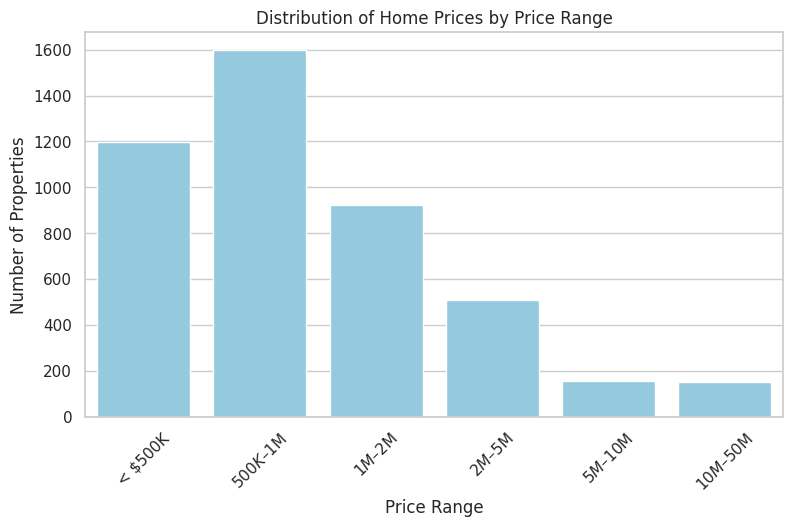

In [86]:
#Distribution of Home Prices

plt.figure(figsize=(9,5))
sns.countplot(x='price_range', data=df_clean, color='skyblue', order=labels)
plt.title('Distribution of Home Prices by Price Range')
plt.xlabel('Price Range')
plt.ylabel('Number of Properties')
plt.xticks(rotation=45)
plt.show()

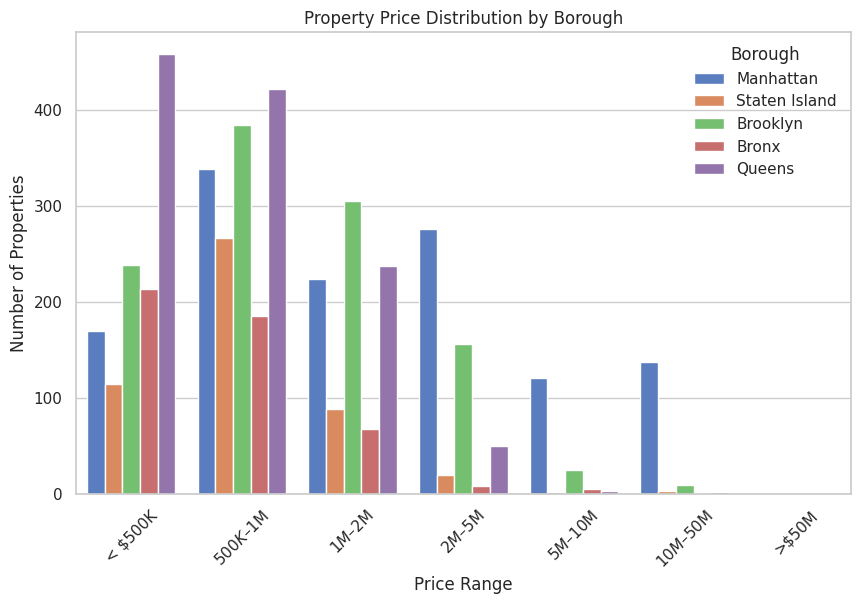

In [87]:
#Property Price Distribution by Borough

plt.figure(figsize=(10,6))
sns.countplot(x='price_range', hue='borough', data=df_clean,
              order=['< $500K', '$500K–$1M', '$1M–$2M', '$2M–$5M', '$5M–$10M', '$10M–$50M', '>$50M'])
plt.title('Property Price Distribution by Borough')
plt.xlabel('Price Range')
plt.ylabel('Number of Properties')
plt.legend(title='Borough')
plt.xticks(rotation=45)
plt.show()

/tmp/ipython-input-3596759082.py:11: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='borough', y='price', data=df_clean, estimator=np.median, order=order, palette='crest')


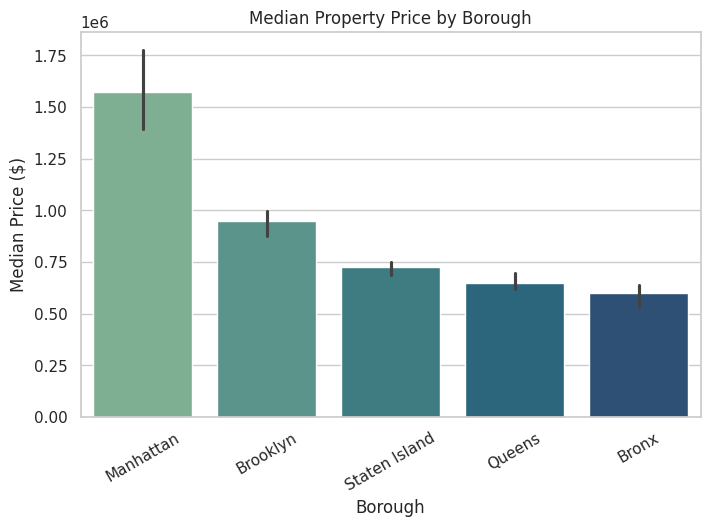

In [88]:
#Median Property Price by Borough

order = (
    df_clean.groupby('borough')['price']
    .median()
    .sort_values(ascending=False)
    .index
)

plt.figure(figsize=(8,5))
sns.barplot(x='borough', y='price', data=df_clean, estimator=np.median, order=order, palette='crest')
plt.title('Median Property Price by Borough')
plt.xlabel('Borough')
plt.ylabel('Median Price ($)')
plt.xticks(rotation=30)
plt.show()

/tmp/ipython-input-2301980786.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


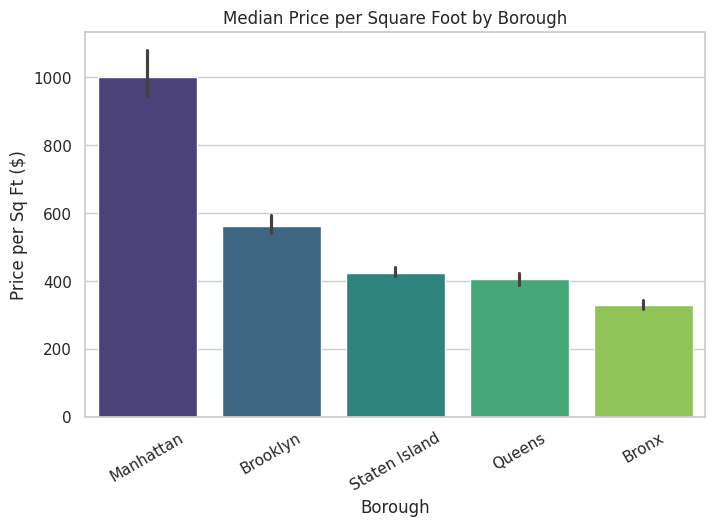

In [89]:
#Median Price per Square Foot by Borough

plt.figure(figsize=(8,5))
sns.barplot(
    x='borough',
    y='price_per_sqft',
    data=df_clean,
    estimator=np.median,
    order=order,
    palette='viridis'
)
plt.title('Median Price per Square Foot by Borough')
plt.xlabel('Borough')
plt.ylabel('Price per Sq Ft ($)')
plt.xticks(rotation=30)
plt.show()


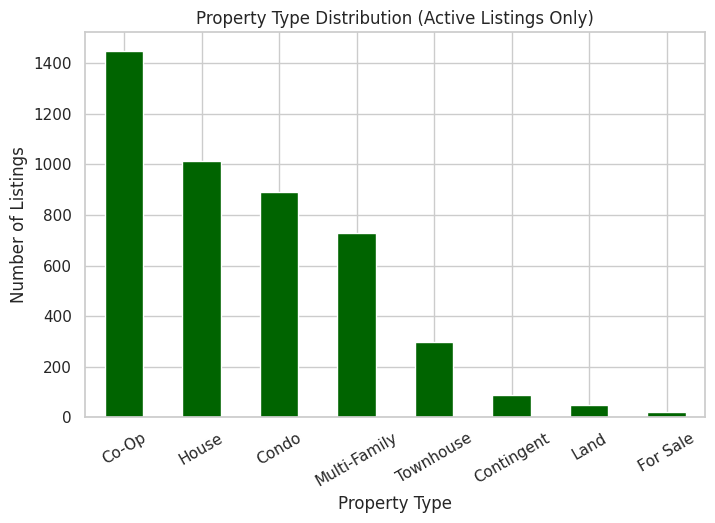

In [90]:
# Property Type Distribution

plt.figure(figsize=(8,5))
df_clean['type'].value_counts().plot(kind='bar', color='darkgreen')
plt.title('Property Type Distribution (Active Listings Only)')
plt.xlabel('Property Type')
plt.ylabel('Number of Listings')
plt.xticks(rotation=30)
plt.show()

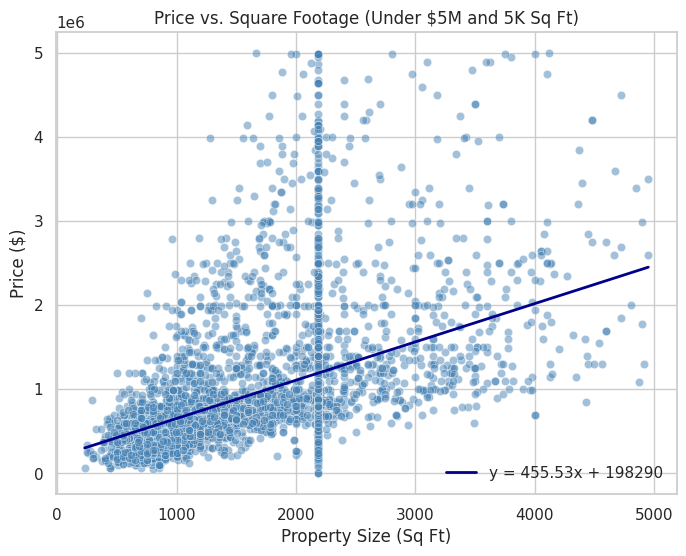

In [91]:
#Price vs. Square Footage

subset = df_clean[(df_clean['price'] < 5_000_000) & (df_clean['propertysqft'] < 5_000)]

m, b = np.polyfit(subset['propertysqft'], subset['price'], 1)

plt.figure(figsize=(8,6))
sns.scatterplot(x='propertysqft', y='price', data=subset, color='steelblue', alpha=0.5)

x_vals = np.linspace(subset['propertysqft'].min(), subset['propertysqft'].max(), 100)
y_vals = m * x_vals + b
plt.plot(x_vals, y_vals, color='darkblue', linewidth=2, label=f'y = {m:.2f}x + {b:.0f}')

plt.title('Price vs. Square Footage (Under $5M and 5K Sq Ft)')
plt.xlabel('Property Size (Sq Ft)')
plt.ylabel('Price ($)')
plt.legend()
plt.show()

/tmp/ipython-input-2155157202.py:4: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='beds', y='price', data=df_clean, estimator=np.median, palette='crest')


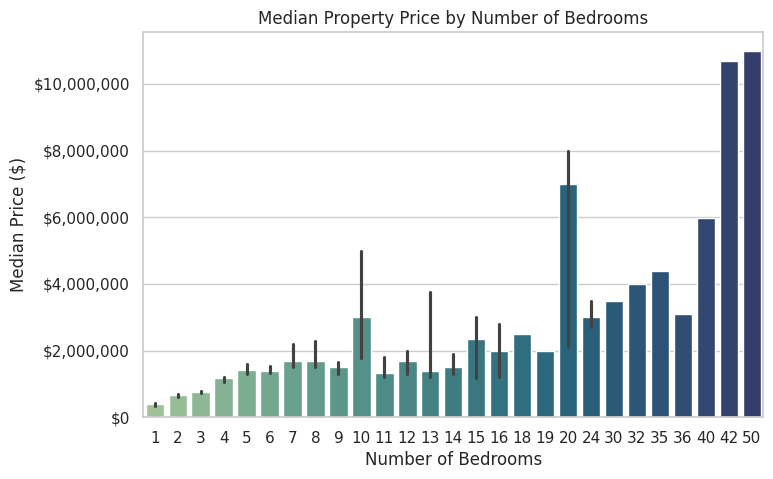

In [92]:
#Median Property Price by Number of Bedrooms

plt.figure(figsize=(8,5))
sns.barplot(x='beds', y='price', data=df_clean, estimator=np.median, palette='crest')
plt.title('Median Property Price by Number of Bedrooms')
plt.xlabel('Number of Bedrooms')
plt.ylabel('Median Price ($)')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.show()


/tmp/ipython-input-3269634892.py:2: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(x='bath', y='price', data=df_clean, estimator=np.median, palette='crest')


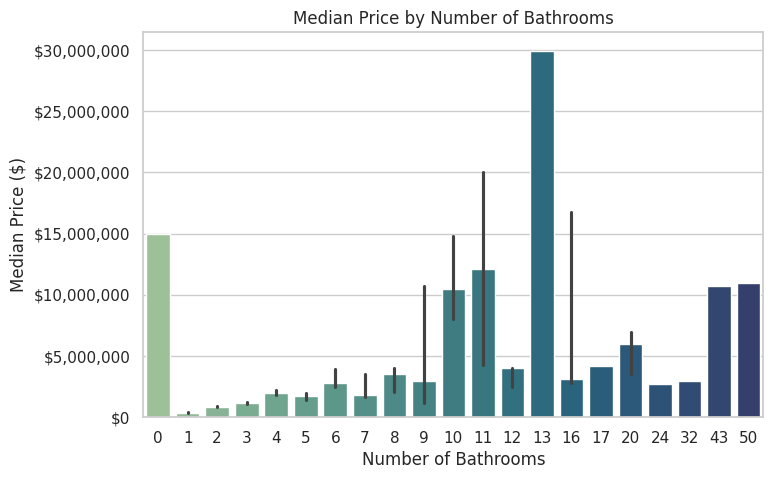

In [93]:
plt.figure(figsize=(8,5))
sns.barplot(x='bath', y='price', data=df_clean, estimator=np.median, palette='crest')
plt.title('Median Price by Number of Bathrooms')
plt.xlabel('Number of Bathrooms')
plt.ylabel('Median Price ($)')
plt.gca().yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))
plt.show()

/tmp/ipython-input-675778735.py:68: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-675778735.py:84: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-675778735.py:135: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/tmp/ipython-input-675778735.py:149: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


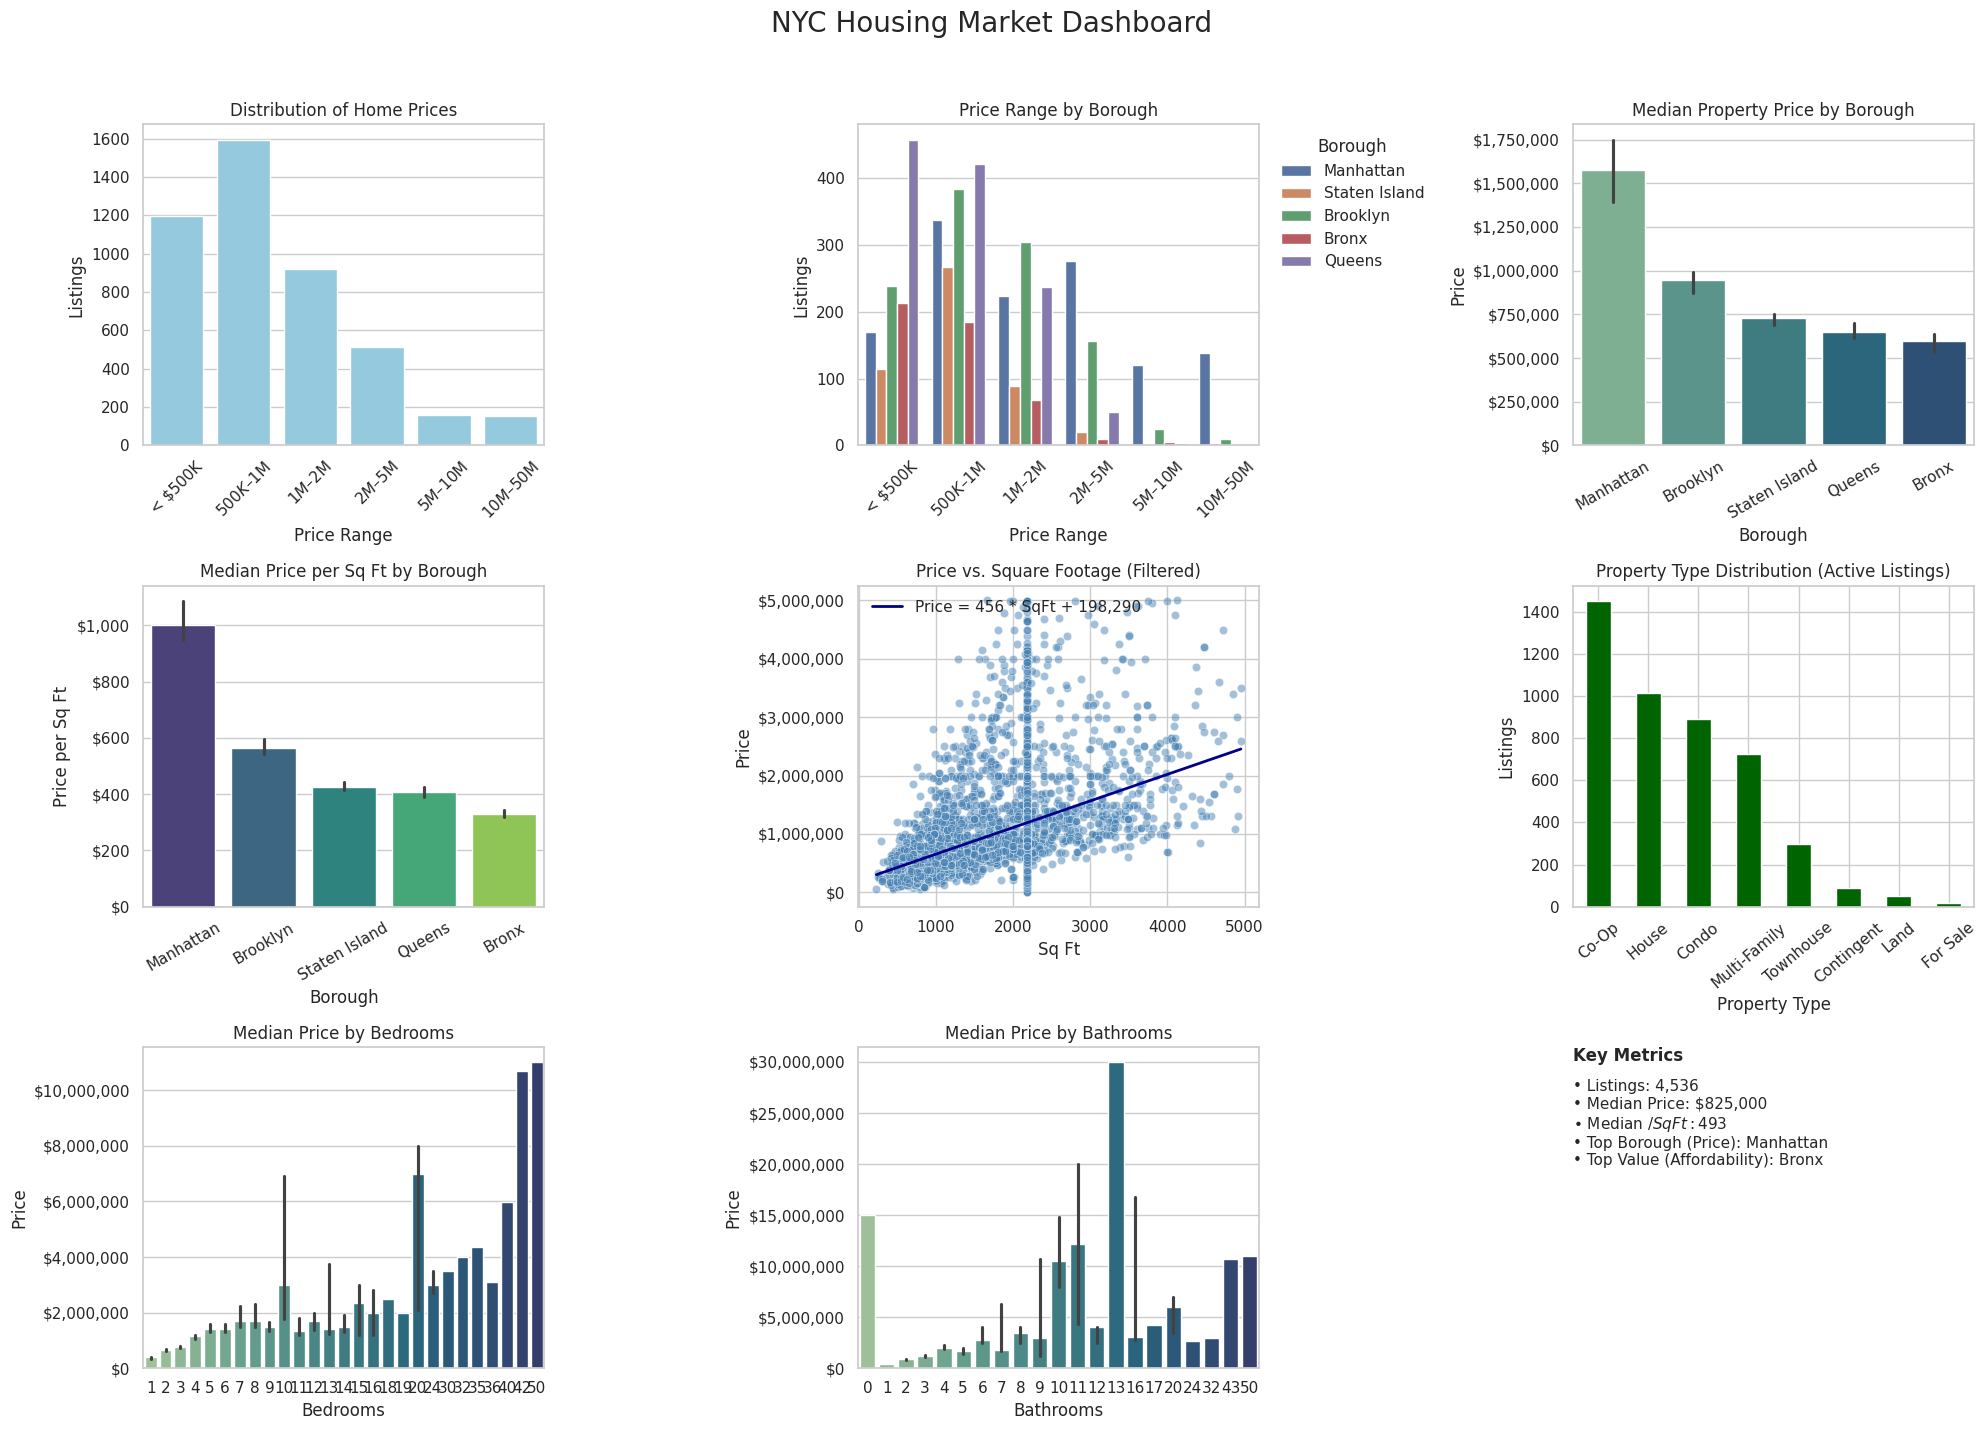

Dashboard created and saved as nyc_housing_dashboard.png


In [98]:
sns.set_theme(style="whitegrid")

# use cleaned datasets
DF = df_clean.copy()
DF_scatter = df_trimmed.copy() if 'df_trimmed' in globals() else DF

# use existing price_range categories as the x-axis order
if hasattr(DF['price_range'], "cat"):
    price_labels = DF['price_range'].cat.categories.tolist()
else:
    price_labels = sorted(DF['price_range'].dropna().unique().tolist())

# sort orders for boroughs
order_price = (
    DF.groupby('borough')['price']
      .median()
      .sort_values(ascending=False)
      .index
)
order_pps = (
    DF.groupby('borough')['price_per_sqft']
      .median()
      .sort_values(ascending=False)
      .index
)

# subset for scatter
subset = DF_scatter[
    (DF_scatter['price'] < 5_000_000) &
    (DF_scatter['propertysqft'] < 5_000)
]

# linear regression for price vs. square footage
m, b = np.polyfit(subset['propertysqft'], subset['price'], 1)

# DASHBOARD LAYOUT
fig, axes = plt.subplots(3, 3, figsize=(20, 14))
fig.suptitle('NYC Housing Market Dashboard', fontsize=20, y=1.02)

# 1. Distribution of Home Prices
sns.countplot(
    x='price_range',
    data=DF,
    color='skyblue',
    order=price_labels,
    ax=axes[0,0]
)
axes[0,0].set_title('Distribution of Home Prices')
axes[0,0].set_xlabel('Price Range')
axes[0,0].set_ylabel('Listings')
axes[0,0].tick_params(axis='x', rotation=45)

# 2. Price Range by Borough
sns.countplot(
    x='price_range',
    hue='borough',
    data=DF,
    order=price_labels,
    ax=axes[0,1]
)
axes[0,1].set_title('Price Range by Borough')
axes[0,1].set_xlabel('Price Range')
axes[0,1].set_ylabel('Listings')
axes[0,1].tick_params(axis='x', rotation=45)
axes[0,1].legend(title='Borough', bbox_to_anchor=(1.02, 1), loc='upper left')

# 3. Median Property Price by Borough
sns.barplot(
    x='borough',
    y='price',
    data=DF,
    estimator=np.median,
    order=order_price,
    palette='crest',
    ax=axes[0,2]
)
axes[0,2].set_title('Median Property Price by Borough')
axes[0,2].set_xlabel('Borough')
axes[0,2].set_ylabel('Price')
fmt_currency(axes[0,2])
axes[0,2].tick_params(axis='x', rotation=30)

# 4. Median Price per Sq Ft by Borough
sns.barplot(
    x='borough',
    y='price_per_sqft',
    data=DF,
    estimator=np.median,
    order=order_pps,
    palette='viridis',
    ax=axes[1,0]
)
axes[1,0].set_title('Median Price per Sq Ft by Borough')
axes[1,0].set_xlabel('Borough')
axes[1,0].set_ylabel('Price per Sq Ft')
axes[1,0].tick_params(axis='x', rotation=30)
axes[1,0].yaxis.set_major_formatter(mtick.StrMethodFormatter('${x:,.0f}'))

# 5. Price vs. Square Footage (using trimmed data if available)
sns.scatterplot(
    x='propertysqft',
    y='price',
    data=subset,
    color='steelblue',
    alpha=0.5,
    ax=axes[1,1]
)
x_vals = np.linspace(subset['propertysqft'].min(),
                     subset['propertysqft'].max(), 200)
axes[1,1].plot(
    x_vals,
    m * x_vals + b,
    color='darkblue',
    linewidth=2,
    label=f'Price = {m:,.0f} * SqFt + {b:,.0f}'
)
axes[1,1].set_title('Price vs. Square Footage (Filtered)')
axes[1,1].set_xlabel('Sq Ft')
axes[1,1].set_ylabel('Price')
fmt_currency(axes[1,1])
axes[1,1].legend()

# 6. Property Type Distribution
DF['type'].value_counts().plot(
    kind='bar',
    color='darkgreen',
    ax=axes[1,2]
)
axes[1,2].set_title('Property Type Distribution (Active Listings)')
axes[1,2].set_xlabel('Property Type')
axes[1,2].set_ylabel('Listings')
axes[1,2].tick_params(axis='x', rotation=40)

# 7. Median Price by Bedrooms
sns.barplot(
    x='beds',
    y='price',
    data=DF,
    estimator=np.median,
    palette='crest',
    ax=axes[2,0]
)
axes[2,0].set_title('Median Price by Bedrooms')
axes[2,0].set_xlabel('Bedrooms')
axes[2,0].set_ylabel('Price')
fmt_currency(axes[2,0])

# 8. Median Price by Bathrooms
sns.barplot(
    x='bath',
    y='price',
    data=DF,
    estimator=np.median,
    palette='crest',
    ax=axes[2,1]
)
axes[2,1].set_title('Median Price by Bathrooms')
axes[2,1].set_xlabel('Bathrooms')
axes[2,1].set_ylabel('Price')
fmt_currency(axes[2,1])

# 9. KPI Summary Panel
ax = axes[2,2]
ax.axis('off')
kpis = {
    "Listings": f"{len(DF):,}",
    "Median Price": f"${DF['price'].median():,.0f}",
    "Median $/Sq Ft": f"${DF['price_per_sqft'].median():,.0f}",
    "Top Borough (Price)": DF.groupby('borough')['price'].median().idxmax(),
    "Top Value (Affordability)": DF.groupby('borough')['price_per_sqft'].median().idxmin(),
}
text = "\n".join([f"• {k}: {v}" for k, v in kpis.items()])
ax.text(0, 1, "Key Metrics", fontsize=12, fontweight='bold', va='top')
ax.text(0, 0.9, text, fontsize=11, va='top')

plt.tight_layout()
plt.savefig('nyc_housing_dashboard.png', dpi=200, bbox_inches='tight')
plt.show()

print("Dashboard created and saved as nyc_housing_dashboard.png")
